In [2]:
!source venv/bin/activate  # Windows: venv\Scripts\activate

'source' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!pip install Flask tensorflow opencv-python numpy

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import torch

In [48]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
input_height, input_width = model.classifier[0].convs[0][0].weight.shape[2:]
print(f"Input Height: {input_height}, Input Width: {input_width}")
model.eval()

Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0


Input Height: 1, Input Width: 1


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [30]:
def preprocess_image(image):
    # Resize to model's input size
    image = cv2.resize(image, (input_height, input_width))
    # Normalize pixel values (typical range: 0-1 or -1 to 1)
    image = image / 255.0
     # Convert toCHW format (channels first) expected by PyTorch models
    image = image.transpose((2, 0, 1))  
    # Convert NumPy array to PyTorch tensor
    image = torch.from_numpy(image).float()

    # Expand dimensions for batch processing (if needed)
    image = image.unsqueeze(0)
    return image


In [53]:
image_path = r'C:\Users\Admin\Desktop\ds_internship\day_8\home.jpeg'
image = cv2.imread(image_path)
check = preprocess_image(image)

from PIL import Image
from torchvision import transforms
input_image = Image.open(image_path)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)


print(output_predictions)



tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


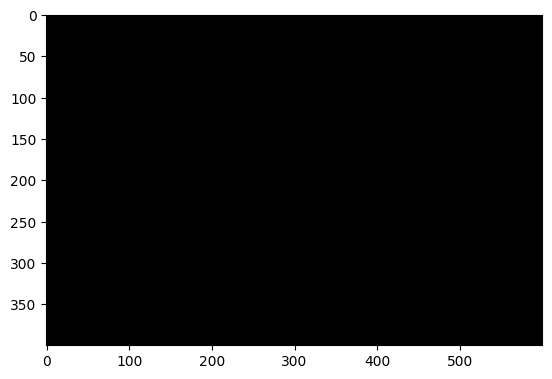

In [54]:
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()